In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rc
import matplotlib.animation as animation
from IPython.display import HTML, Image

from scipy import integrate
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam
from keras.models import load_model

from rl.agents.dqn import DQNAgent
from rl.policy import EpsGreedyQPolicy, LinearAnnealedPolicy
from rl.memory import SequentialMemory
%load_ext autoreload

Using TensorFlow backend.


In [2]:
from PFRorCSTR import simulator

In [3]:
env = simulator(volume = 0.8, n_reactors=4)
nb_actions = env.action_space.n
env.observation_space, env.action_space

(Box(1,), Discrete(2))

## If running a reloaded model:

In [10]:
model = load_model("DQN_agent.h5")
print(model.summary())
steps = 15000
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=.05, value_test=0, nb_steps=steps)
memory = SequentialMemory(limit=50000, window_length=1)
dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=9,
target_model_update=1e-2, policy=policy, gamma = 0.95)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 1)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                32        
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 34        
Total params: 610
Trainable params: 610
Non-trainable params: 0
_________________________________________________________________
None


## Otherwise make model from scratch as below

In [59]:
%autoreload

In [6]:
nb_actions

2

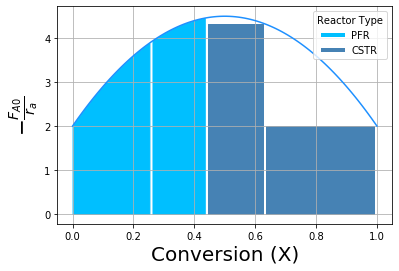

In [7]:
label_size = 20
X = np.linspace(0, 1, 100)
Y = -10*X**2 + 10*X + 2
plt.plot(X, Y, color = "dodgerblue")
plt.xlabel("Conversion (X)", fontsize=label_size)
plt.ylabel(r"$ - \frac{F_{A0}}{r_a} $", fontsize=label_size)
plt.grid(True)

previous_index = 0
conversion = 0
X_out_PFR = []
X_out_CSTR = []
X_react = []
Y_react = []
color = []

while conversion < 0.4:
    conversion = env.equation_solver(1, conversion)
    X_out_PFR.append(conversion)
    index = np.where(abs(X - conversion) == min(abs(X - conversion)))[0][0]
    X_react.append(X[previous_index:index])
    Y_react.append(Y[previous_index:index])
    previous_index = index
    color.append("deepskyblue")
  
while conversion > 0.4 and conversion <= 0.9:
    conversion = env.equation_solver(0, conversion)
    X_out_CSTR.append(conversion)
    index = np.where(abs(X - conversion) == min(abs(X - conversion)))[0][0]
    X_react.append(X[previous_index:index])
    Y_react.append(np.zeros(X_react[-1].shape) + Y[index])
    previous_index = index
    color.append("steelblue")



for i in range(len(X_react)):
    plt.fill_between(X_react[i], Y_react[i], color = color[i])

    
legend_elements = [matplotlib.lines.Line2D([0], [0], c="deepskyblue", lw=4, label='PFR'),
                   matplotlib.lines.Line2D([0], [0], c="steelblue", lw=4, label='CSTR')] 

plt.legend(handles = legend_elements, title = "Reactor Type", loc = 1)
plt.savefig('Ideal_Soln.png', bbox_inches='tight')

In [8]:
X_out_PFR[-1], X_out_CSTR[0]

(0.44804425979999357, 0.6331085954859981)

## Doube check volumes are correct to make sure simulator solver is working

In [9]:
def PFR(x):
    return -10*x**2 + 10*x + 2
def CSTR_vol(x, x_in):
    return (-10*x**2 + 10*x + 2)*(x - x_in)

PFR1 = integrate.quad(PFR, 0,  X_out_PFR[0])[0]
PFR2 = integrate.quad(PFR, X_out_PFR[0], X_out_PFR[1] )
CSTR1 = CSTR_vol(X_out_CSTR[0], X_out_PFR[-1])


PFR1, PFR2, CSTR1

(0.7999999999999999,
 (0.8000000000000004, 8.881784197001257e-15),
 0.8000000000000009)

In [5]:
# Next, we build a very simple model.
model = Sequential()
model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(nb_actions, activation = 'linear'))
print(model.summary())

W1026 17:29:23.572457  7932 deprecation_wrapper.py:119] From C:\Users\meatrobot\Anaconda3\envs\RL\lib\site-packages\keras\backend\tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1026 17:29:23.591434  7932 deprecation_wrapper.py:119] From C:\Users\meatrobot\Anaconda3\envs\RL\lib\site-packages\keras\backend\tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1026 17:29:23.608360  7932 deprecation_wrapper.py:119] From C:\Users\meatrobot\Anaconda3\envs\RL\lib\site-packages\keras\backend\tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 1)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                32        
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 34        
Total params: 610
Trainable params: 610
Non-trainable params: 0
_________________________________________________________________
None


In [6]:
steps = 15000
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=.05, value_test=0, nb_steps=steps)
memory = SequentialMemory(limit=50000, window_length=1)
dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=9,
target_model_update=1e-2, policy=policy, gamma = 0.95)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

W1026 17:29:27.133553  7932 deprecation_wrapper.py:119] From C:\Users\meatrobot\Anaconda3\envs\RL\lib\site-packages\keras\backend\tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W1026 17:29:27.134583  7932 deprecation_wrapper.py:119] From C:\Users\meatrobot\Anaconda3\envs\RL\lib\site-packages\keras\backend\tensorflow_backend.py:197: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W1026 17:29:27.265235  7932 deprecation_wrapper.py:119] From C:\Users\meatrobot\Anaconda3\envs\RL\lib\site-packages\keras\optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [7]:
# Okay, now it's time to learn something! We visualize the training here for show, but this slows down training quite a lot. 
hist = dqn.fit(env, nb_steps=steps)

Training for 15000 steps ...
Interval 1 (0 steps performed)
    1/10000 [..............................] - ETA: 11:17 - reward: 0.2601

C:\Users\meatrobot\Anaconda3\envs\RL\lib\site-packages\rl\memory.py:39: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')


10000/10000 [==============================] - 42s 4ms/step - reward: 0.2143
2500 episodes - episode_reward: 0.857 [0.769, 1.000] - loss: 0.000 - mean_absolute_error: 0.266 - mean_q: 0.526 - mean_eps: 0.683

Interval 2 (10000 steps performed)
 4998/10000 [=============>................] - ETA: 20s - reward: 0.2358done, took 62.240 seconds


In [23]:
reward_data = np.array(hist.history["episode_reward"])

In [24]:
np.savetxt("rewards.csv", reward_data, delimiter=",")

In [37]:
reward_data = np.loadtxt("rewards.csv", delimiter = ",")

In [6]:
model.save("DQN_agent.h5")

In [14]:
print(hist.history.keys())

dict_keys(['episode_reward', 'nb_episode_steps', 'nb_steps'])


In [42]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

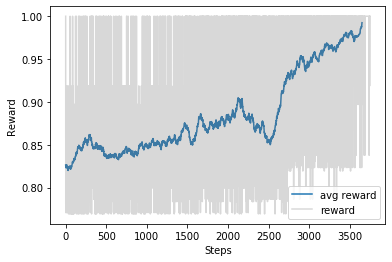

In [44]:
smoothed_rews = running_mean(reward_data, 100)
plt.plot(np.arange(np.shape(smoothed_rews)[0])[-len(smoothed_rews):], smoothed_rews)
plt.plot(np.arange(np.shape(reward_data)[0]),reward_data,color='grey', alpha=0.3)
plt.xlabel("Steps")
plt.ylabel("Reward")
plt.legend(["avg reward", "reward"])
plt.savefig('Learning.png', bbox_inches='tight')

In [12]:
dqn.test(env, visualize = True)

Testing for 1 episodes ...
choice(1) - conversions: [0, 0.2601494936395941], reactors: [1]
choice(2) - conversions: [0, 0.2601494936395941, 0.44804425979999357], reactors: [1, 1]
choice(3) - conversions: [0, 0.2601494936395941, 0.44804425979999357, 0.6331085954859981], reactors: [1, 1, 0]
choice(4) - conversions: [0, 0.2601494936395941, 0.44804425979999357, 0.6331085954859981, 1], reactors: [1, 1, 0, 0]
Episode 1: reward: 1.000, steps: 4


In [13]:
env.reactor_seq, env.X

([1, 1, 0, 0],
 [0, 0.2601494936395941, 0.44804425979999357, 0.6331085954859981, 1])

In [14]:
y = [] 
x = []
CSTR = []
PFR = []
for i in range(0, 100):
    x.append(i/140)
    CSTR.append(env.equation_solver(0, x[i]))
    PFR.append(env.equation_solver(1, x[i]))
x_sim = env.X[0:-1]
choice = env.X[1:]

In [15]:
#%matplotlib inline
#%matplotlib auto

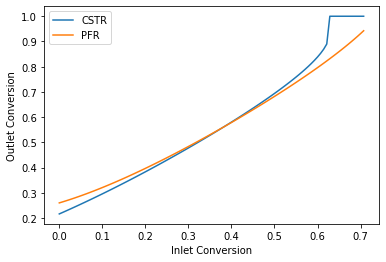

In [16]:
fig, ax = plt.subplots()
ax.plot(x, CSTR)
ax.plot(x, PFR)
ax.legend(["CSTR", "PFR", "CHOICE"])
ax.set_xlabel("Inlet Conversion")
ax.set_ylabel("Outlet Conversion")
line, = ax.plot([], [], '--go', lw=2)

In [17]:
# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)

In [18]:
def animate(i):
    line.set_data(x_sim[0:i+1], choice[0:i+1])
    return (line,)

In [8]:
rc('animation', html='html5')

In [20]:
anim = animation.FuncAnimation(fig, animate, init_func = init, frames = len(x_sim), interval = 1000, blit = True)

In [21]:
anim.save('PFRCSTRconversion.gif', writer='imagemagick', fps=1)

In [22]:
"""
Writer = animation.writers['ffmpeg']
writer = Writer(fps=1, metadata=dict(artist='Me'))
anim.save("PFRorCSTR_conversion.mp4", writer = writer)
"""

'\nWriter = animation.writers[\'ffmpeg\']\nwriter = Writer(fps=1, metadata=dict(artist=\'Me\'))\nanim.save("PFRorCSTR_conversion.mp4", writer = writer)\n'

In [23]:
Image(url='PFRCSTRconversion.gif')

In [24]:
#HTML(anim.to_html5_video())

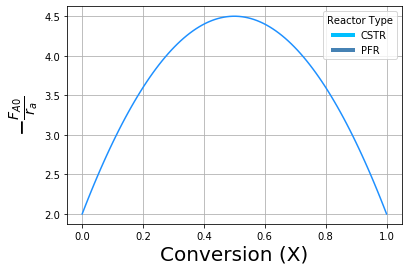

In [25]:
label_size = 20
X = np.linspace(0, 1, 100)
Y = -10*X**2 + 10*X + 2
fig, ax = plt.subplots()
ax.plot(X, Y, color = "dodgerblue")
ax.set_xlabel("Conversion (X)", fontsize=label_size)
ax.set_ylabel(r"$ - \frac{F_{A0}}{r_a} $", fontsize=label_size)
ax.grid(True)


legend_elements = [matplotlib.lines.Line2D([0], [0], c="deepskyblue", lw=4, label='CSTR'),
                   matplotlib.lines.Line2D([0], [0], c="steelblue", lw=4, label='PFR')] 

ax.legend(handles = legend_elements, title = "Reactor Type", loc = 1)
fills = [ax.fill_between([], [])]

In [26]:
def livenspiel_plotter(conversion_in, conversion_out, choice, X_data, Y_data, ax):
    index_in = np.where(abs(X_data - conversion_in) == min(abs(X_data - conversion_in)))[0][0]
    index_out = np.where(abs(X_data - conversion_out) == min(abs(X_data - conversion_out)))[0][0]
    x = X_data[index_in:index_out]
    if choice == 0: # CSTR
        y = np.zeros(x.shape) + Y_data[index_out]
        fill = ax.fill_between(x, y, color = "deepskyblue")
        
    if choice == 1: # PFR
        y = Y_data[index_in:index_out]
        fill = ax.fill_between(x, y, color = "steelblue")
    
    fills.append(fill)    
    return fills

In [27]:
def animate(i):
    fills = livenspiel_plotter(env.X[i], env.X[i+1], env.reactor_seq[i], X, Y, ax)
    return fills

In [28]:
livenspiel_anim = animation.FuncAnimation(fig, animate, frames = len(env.X)-1, interval = 1000, blit = True)

In [29]:
livenspiel_anim.save('Livenspiel.gif', writer='imagemagick', fps=1)

In [30]:
Image(url='Livenspiel.gif')

In [17]:
import pydot
from IPython.display import Image, display
import imageio

In [18]:
reactor_type = ["CSTR", "PFR"]
shapes = ["square", "rectangle"]
G = pydot.Dot(graph_type="digraph", rankdir = "LR", size = "20, 4!")
nodes = []
edges = []
image_list = []

In [19]:
matplotlib.rcParams['figure.dpi']= 400

In [20]:
for i in range(len(env.X)-1):
    r_type = reactor_type[env.reactor_seq[i]]
    Xin = round(env.X[i],2)
    Xout = round(env.X[i + 1],2)
    nodes.append(pydot.Node(f'{i+1} \n {r_type} \n Xin {Xin} \n Xout {Xout}', 
                            height = 2, shape = shapes[env.reactor_seq[i]], fixed_size = True))
    G.add_node(nodes[i])
    if i > 0:
        edges.append(pydot.Edge(nodes[i-1], nodes[i]))
        G.add_edge(edges[i-1])
    BFD = imageio.imread(G.create_png()) # converts to np array
    image_list.append(BFD)

In [21]:
BFD.shape, image_list[0].shape

((384, 1405, 4), (384, 212, 4))

(0.0, 20.0, 0.0, 1.0)

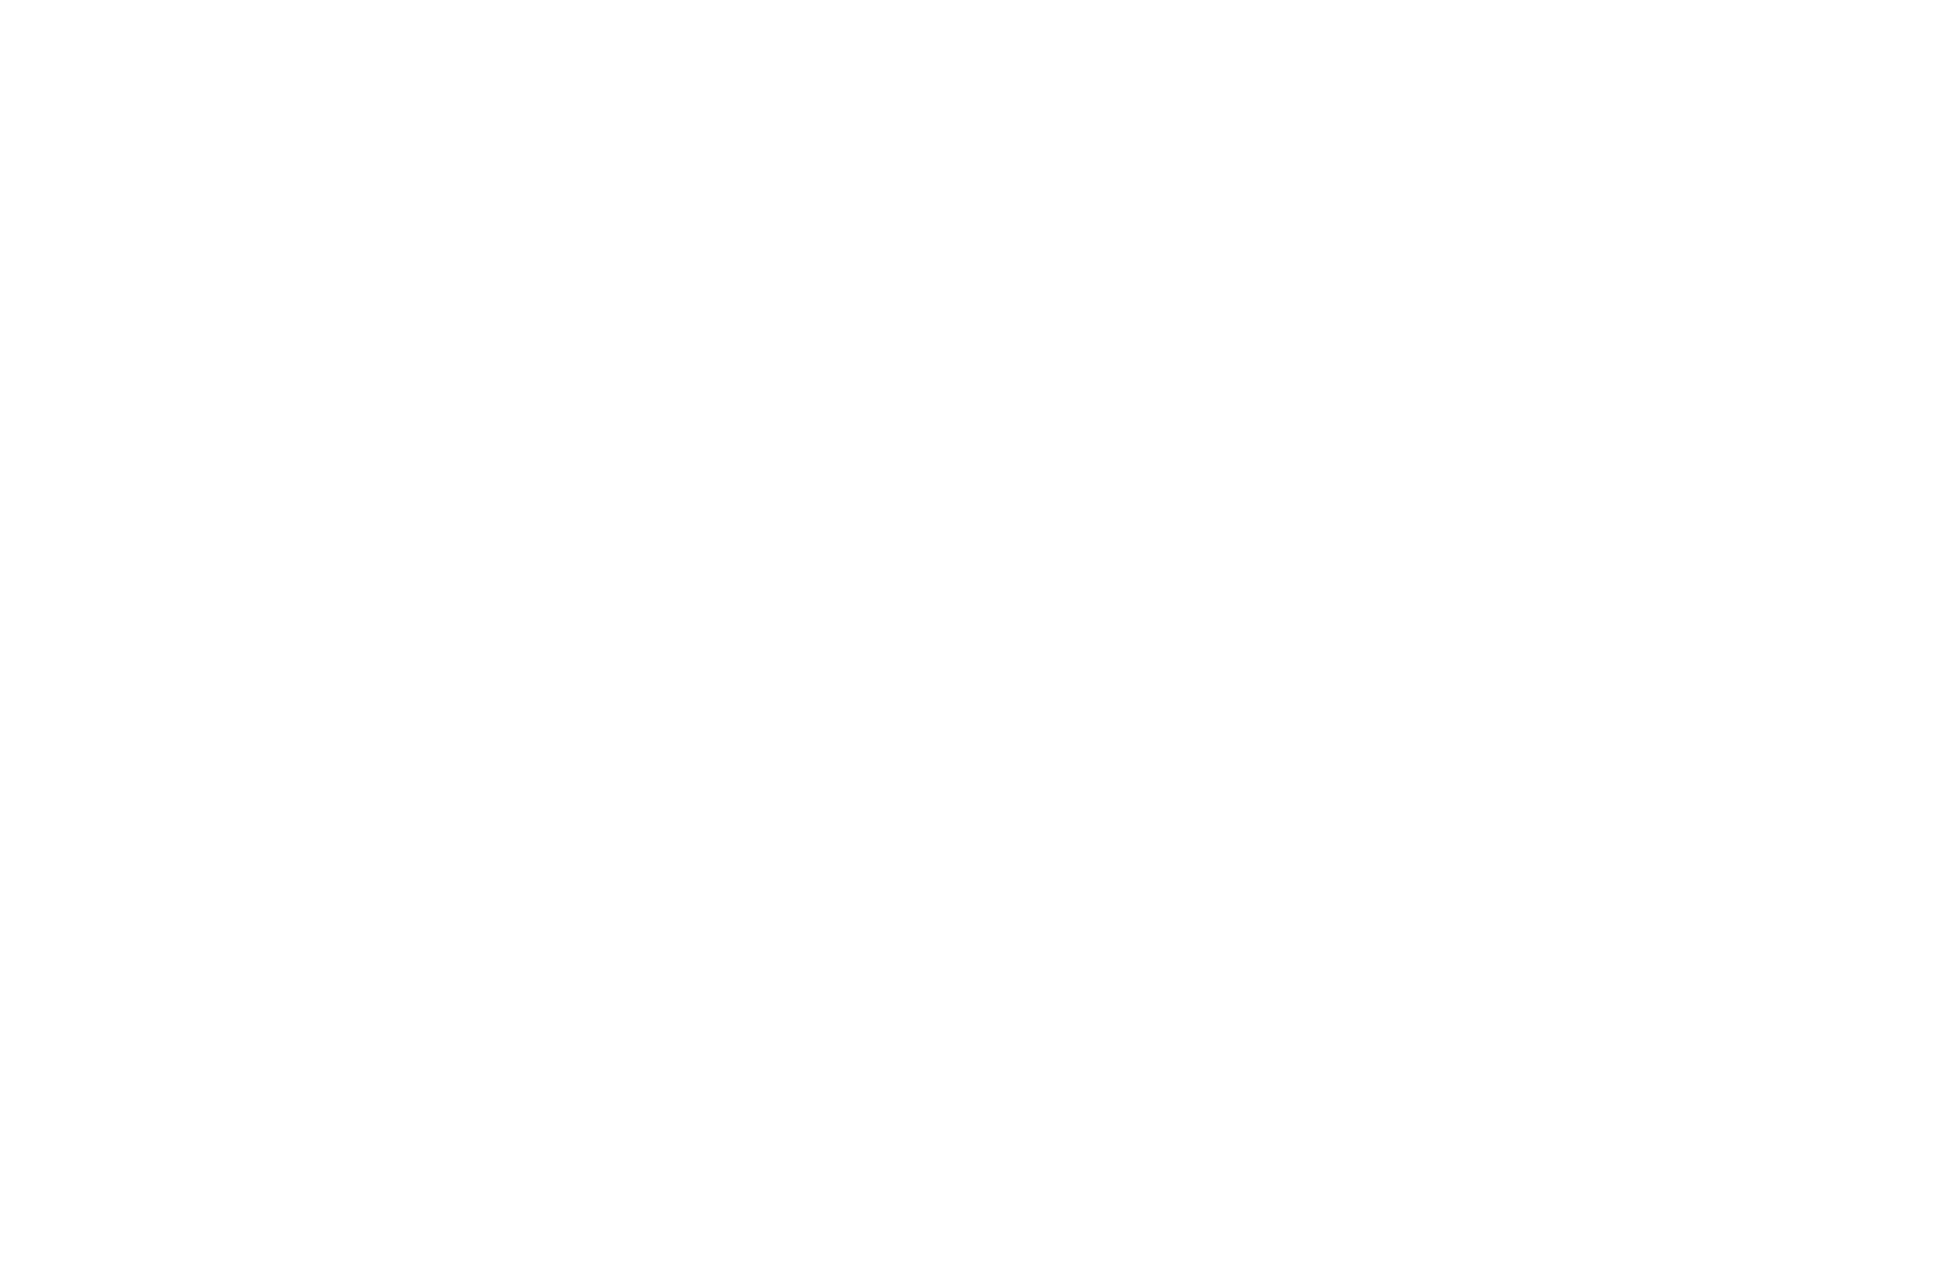

In [22]:
max_width = 20
fig, ax = plt.subplots()
ax.set_xlim(0,max_width)
ax.axis('off')

In [23]:
images = []
final_image_width = image_list[-1].shape[1]
for i in range(len(env.X)-1):
    image_width = image_list[i].shape[1]
    image = ax.imshow(image_list[i], extent = [0, max_width*image_width/final_image_width, 0, 4])
    images.append([image])

In [24]:
animation_BFD = animation.ArtistAnimation(fig, images, interval=1000, blit=True,
                                repeat_delay=1000)
animation_BFD.save('BFD.gif', writer='imagemagick', fps=1)

In [25]:
Image(url='BFD.gif')

In [20]:
"""If you want to save single image
with open("reactor_sequence/BFD.png", "wb") as png:
    png.write(G.create_png())
"""
# imageio.mimsave('reactor_sequence/BFD.gif', image_list) tried to to gif but didn't work because of scaling

'If you want to save single image\nwith open("reactor_sequence/BFD.png", "wb") as png:\n    png.write(G.create_png())\n'

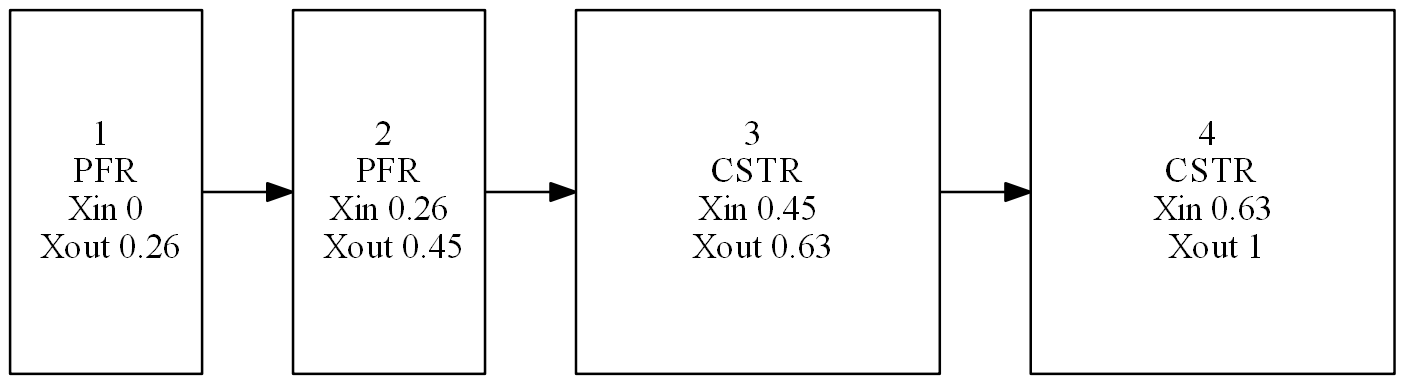

In [301]:
import PIL.Image
import IPython.display
IPython.display.display(PIL.Image.fromarray(image_list[-1]))

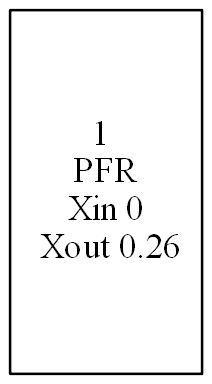

In [302]:
IPython.display.display(PIL.Image.fromarray(image_list[0]))